In [ ]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.cluster.vq import vq
from sklearn.metrics.pairwise import chi2_kernel
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import librosa
%matplotlib inline

In [ ]:
sample_rate = 44100
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

def frame_audio(audio, FFT_size=1024, hop_size=11.6, sample_rate=sample_rate):
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = 512#np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    return frames

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=sample_rate):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel_to_freq(mels)

    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])

    return filters
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)
    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
    return basis
def normalizar_array(array):
    min_val = np.min(array)
    max_val = np.max(array)
    normalized_array = np.interp(array, (min_val, max_val), (0.001, 1.0))
    return normalized_array


In [ ]:
######################### CARACTERÍSTICAS DE LOS AUDIOS TEST ################################3
def caracteristicas(di):
  hop_size = 11.6
  FFT_size = 1024
  freq_min = 0
  mel_filter_num = 36
  dct_filter_num = 21

  s = 2
  y_test = []
  diccionario = {'dream':0, 'energetic':1, 'happy':2, 'sad':3}
  directoryFirst = di
  elementos_directorio = os.listdir(directoryFirst)
  data = np.zeros((2584,20))
  for a, folder_place in enumerate(elementos_directorio):
    directorio = os.path.join(directoryFirst, folder_place)
    datos = os.listdir(directorio)
    for m, files in enumerate(datos):
      directorioMusic = os.path.join(directorio,files)
      audio, sample_rate = librosa.load(directorioMusic)
      freq_high = sample_rate / 2
      audio = normalize_audio(audio)
      audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
      window = get_window("hann", FFT_size, fftbins=True)
      audio_win = audio_framed * window
      audio_winT = np.transpose(audio_win)
      audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
      for n in range(audio_fft.shape[1]):
          audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
      audio_fft = np.transpose(audio_fft)
      filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
      filters = get_filters(filter_points, FFT_size)
      enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
      filters *= enorm[:, np.newaxis]
      audio_power = np.square(np.abs(audio_fft))
      audio_filtered = np.dot(filters, np.transpose(audio_power))
      audio_filtered[audio_filtered == 0] = np.nextafter(0, 1)
      audio_log = 10.0 * np.log10(audio_filtered)
      dct_filters = dct(dct_filter_num, mel_filter_num)
      cepstral_coefficents = np.dot(dct_filters, audio_log)
      cepstral_coefficents = np.transpose(cepstral_coefficents[1:, :])
      data = np.vstack((data,cepstral_coefficents[:1292,:]))
      y_test.append(diccionario[files.split('_')[0]])

      #CARACTERÏSTICA: TEMPOGRAMA
      hop_length = 512
      oenv = librosa.onset.onset_strength(y=audio, sr=sample_rate, hop_length=hop_length)
      ac_tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sample_rate, hop_length=hop_length, norm=None)
      ac_tempogramT = abs(np.transpose(ac_tempogram))
      data = np.vstack((data,ac_tempogramT[:1292,:20]))
  am = data[2584:,:]
  y_test = np.array(y_test)
  return am, y_test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directorioTe = '/content/drive/MyDrive/AudioDS/4_clases/Proyecto_data/Test'
directorioTr = '/content/drive/MyDrive/AudioDS/4_clases/Proyecto_data/Train'
dataTe, y_test = caracteristicas(directorioTe)
dataTr, y_train = caracteristicas(directorioTr)

In [ ]:
datasetTr = normalizar_array(dataTr)
datasetTe = normalizar_array(dataTe)

In [ ]:
class KMedias:
  def __init__(self, n_grupos, n_iter=10):
    self.n_grupos = n_grupos
    self.n_iter = n_iter

  def asigna_puntos_a_centroides(self, X):
    grupos = np.zeros(X.shape[0])
    dists = np.zeros(X.shape[0])
    for i,p in enumerate(X):
      grupos[i] = np.linalg.norm(self.centroides - p, axis = 1).argmin()
      dists[i] = np.linalg.norm(self.centroides - p, axis = 1).min()
    return grupos, dists

  def recalcula_centroides(self, X):
    for i in range(self.n_grupos):
      if(np.any(np.where(self.grupos == i))):
        self.centroides[i,:] = X[np.where(self.grupos == i), :].mean(axis = 1)


  def fit(self, X, grafica=None):
    self.centroides = np.zeros((self.n_grupos, X.shape[1]))

    ## Inicializa centroides con puntos del conjunto elegidos aleatoriamente
    permutacion = np.random.permutation(X.shape[0])
    self.centroides[:, :] = X[permutacion[:self.n_grupos], :]

    es = np.zeros(self.n_iter + 1)
    for it in range(self.n_iter):
      self.grupos, dists = self.asigna_puntos_a_centroides(X)
      es[it] = np.mean(dists**2)
      self.recalcula_centroides(X)

    self.grupos, dists = self.asigna_puntos_a_centroides(X)
    es[-1] = np.mean(dists**2)
    print(es)
    return self.centroides

In [ ]:
mbkm_places = KMedias(n_grupos=7000)
centroides = mbkm_places.fit(datasetTr)

[2.24182866e-05 1.23971956e-05 1.06818292e-05 9.86320003e-06
 9.39653216e-06 9.30474081e-06 9.22146907e-06 9.12767577e-06
 9.04572359e-06 9.03729267e-06 9.03236061e-06]


In [ ]:
def histograma(y,X):
  data = []
  av = 0
  for i in range(len(y)):
    im_featuresTr = np.zeros(centroides.shape[0])
    for j in range(2584):
      words,_ = vq(X[av][np.newaxis,:],centroides)#abs(np.sum((X[av] / centroides) - np.log(centroides / X[av])-1,axis=1)).argmin() #
      im_featuresTr[words[0]] += 1
      av += 1
    data.append(im_featuresTr)
  return np.array(data)

In [ ]:
histTr = histograma(y_train,datasetTr)
histTe = histograma(y_test,datasetTe)

In [ ]:
X_train = normalizar_array(histTr)
X_test = normalizar_array(histTe)

In [ ]:
np.save("/content/drive/MyDrive/AudioDS/4_clases/Proyecto_data/X_train.npy", X_train)
np.save("/content/drive/MyDrive/AudioDS/4_clases/Proyecto_data/X_test.npy", X_test)
np.save("/content/drive/MyDrive/AudioDS/4_clases/Proyecto_data/y_train.npy", y_train)
np.save("/content/drive/MyDrive/AudioDS/4_clases/Proyecto_data/y_test.npy", y_test)

In [ ]:
clf = svm.SVC(kernel = chi2_kernel, C=4)
clf.fit(X_train,y_train)

SVC(C=4, kernel=<function chi2_kernel at 0x7facfc3ac940>)

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6296296296296297


In [ ]:
#{'dream':0, 'energetic':1, 'happy':2, 'sad':3}
corr = confusion_matrix(y_test, y_pred)

In [ ]:
import pandas as pd
import seaborn as sb
df = pd.DataFrame(corr)

<Axes: >

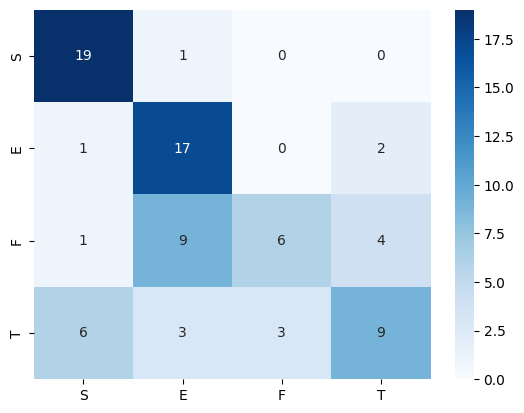

In [ ]:
sb.heatmap(corr, cmap="Blues", annot=True, xticklabels='SEFT', yticklabels='SEFT')